# Computer Vision and CNN #

## Importing Packages and Libraries ##

In [1]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import torch
import numpy as np
import tensorflow as tf

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

In [3]:
## Setup default font sizes for any figure we will be using later
import matplotlib.pyplot as plt

plt.rc('font', size= 14)
plt.rc('axes', labelsize = 14, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

In [4]:
from sklearn.datasets import load_sample_images ##Two images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images)
images = tf.keras.layers.Rescaling(scale = 1/255)(images)

In [5]:
images.shape

TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7)
fmaps = conv_layer(images)

In [7]:
fmaps.shape

TensorShape([2, 64, 114, 32])

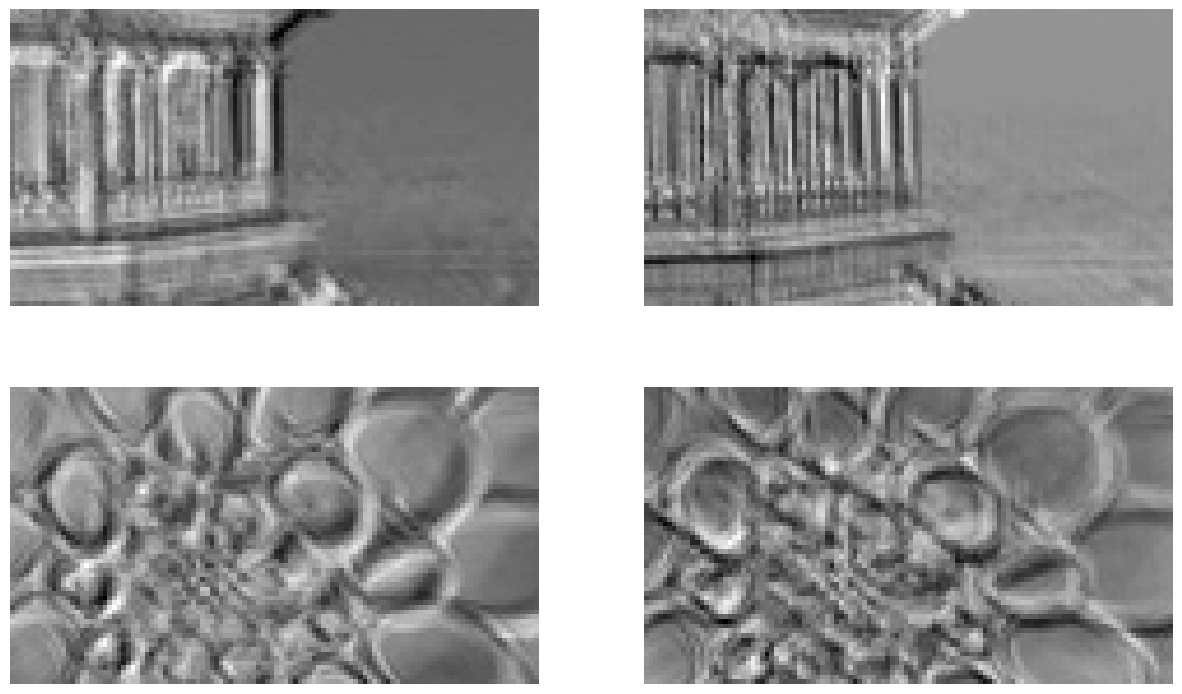

In [8]:
## Feature maps of convolutional layer
plt.figure(figsize = (15, 9))
for image_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap = 'gray')
        plt.axis('off')

plt.show()


In [9]:
## Zero Padding
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = 'same')
fmaps = conv_layer(images)

In [10]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [11]:
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

## Using Pooling Layers with Keras ##

### Max Pooling ###

In [12]:
max_pool = tf.keras.layers.MaxPool2D(pool_size = 2)

In [13]:
output = max_pool(images)

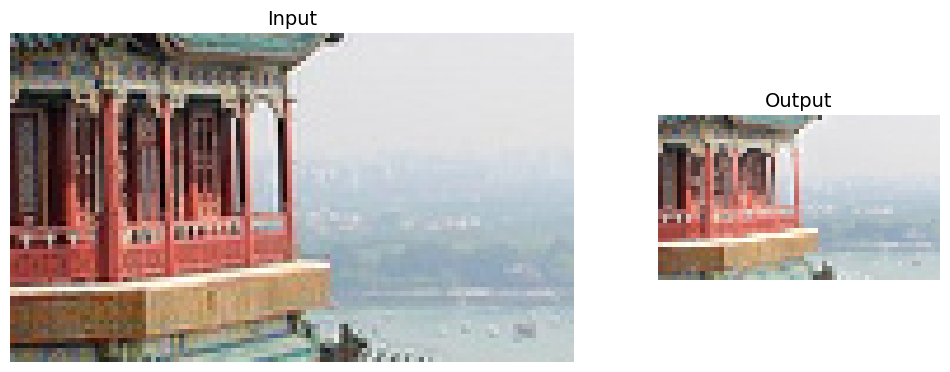

In [14]:
import matplotlib as mpl

fig = plt.figure(figsize =(12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### Global Average Pooling ###

In [15]:
global_average_pooling = tf.keras.layers.GlobalAvgPool2D()

In [16]:
global_average_pooling(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

## CNN Architecture ##

In [17]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis = -1).astype(np.float32)/255 #Fetch and scale training images
X_test = np.expand_dims(X_test.astype(np.float32), axis = -1)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [18]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = 'same',
                        activation = 'relu', kernel_initializer = 'he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu',
                          kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64, activation = 'relu',
                          kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

In [19]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam',
              metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10,
                    validation_data = (X_valid, y_valid))

score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 18s 9ms/step - loss: 0.6847 - accuracy: 0.7664 - val_loss: 0.3501 - val_accuracy: 0.8742
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3876 - accuracy: 0.8707 - val_loss: 0.3007 - val_accuracy: 0.8952
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3281 - accuracy: 0.8885 - val_loss: 0.2837 - val_accuracy: 0.8990
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2987 - accuracy: 0.8988 - val_loss: 0.2656 - val_accuracy: 0.9078
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2755 - accuracy: 0.9071 - val_loss: 0.2474 - val_accuracy: 0.9076
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2584 - accuracy: 0.9128 - val_loss: 0.2735 - val_accuracy: 0.9108
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2409 - accuracy: 0.9180 - val_loss: 0.2656 - val_ac

## Implementing a ResNet-34 CNN Using Keras ##

In [20]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, strides = 1, 
                        padding = 'same', kernel_initializer = 'he_normal',
                        use_bias = False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides = strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1: 
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size = 1, strides = strides),
                tf.keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [21]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size = 7, strides = 2, input_shape = [224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

## Using Pretrained Models from Keras ##

In [22]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')

In [23]:
images = load_sample_images()['images']
images_resized = tf.keras.layers.Resizing(height = 224, width = 224,
                                          crop_to_aspect_ratio= True)(images)

In [24]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [25]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

In [26]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top = 3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba, in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")
        

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


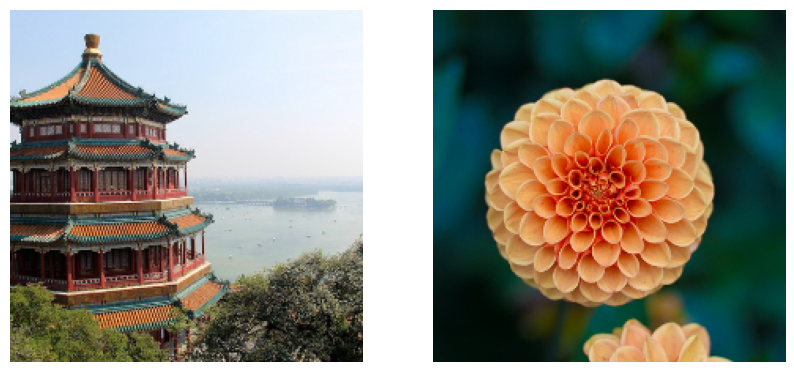

In [27]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

## Pretrained Models for Transfer Learning ##

In [28]:
# !pip install tensorflow-datasets

In [29]:
import tensorflow_datasets as tfds

dataset, info =  tfds.load("tf_flowers", as_supervised = True, with_info = True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [30]:
dataset_size

3670

In [31]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [32]:
n_classes

5

In [33]:
test_set_raw, valid_set_raw, train_set_raw, = tfds.load(
    "tf_flowers",
    split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised = True)

2023-03-15 04:40:58.801418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


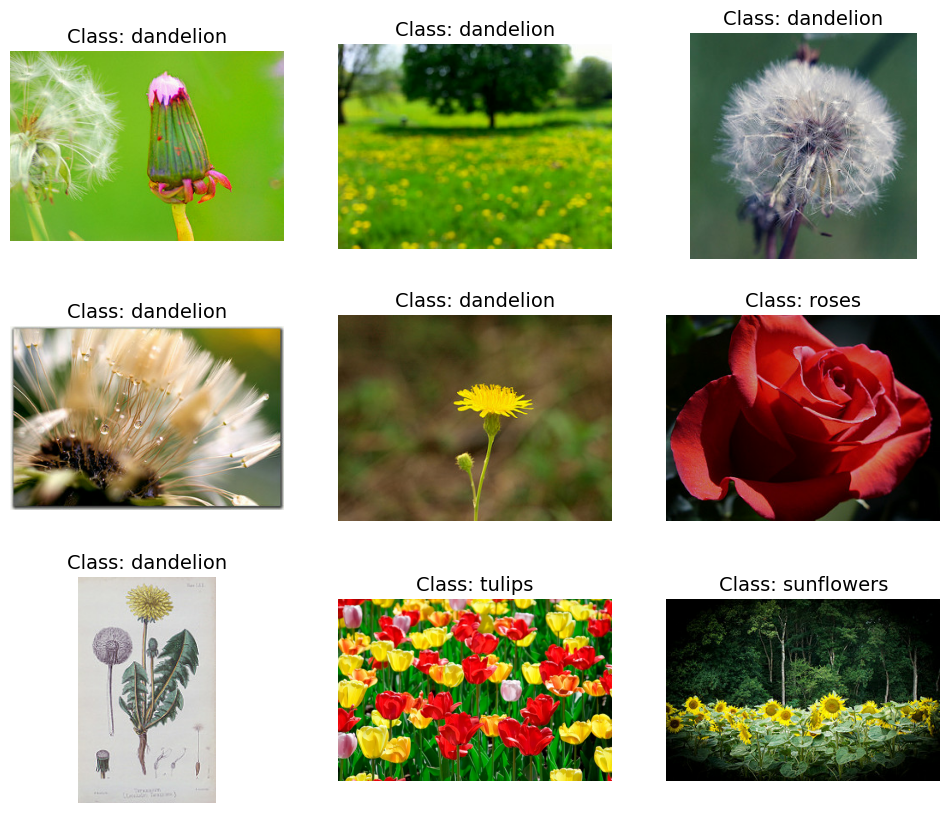

In [34]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [35]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height = 224, width = 224, crop_to_aspect_ratio = True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed = 42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

2023-03-15 04:41:00.325598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


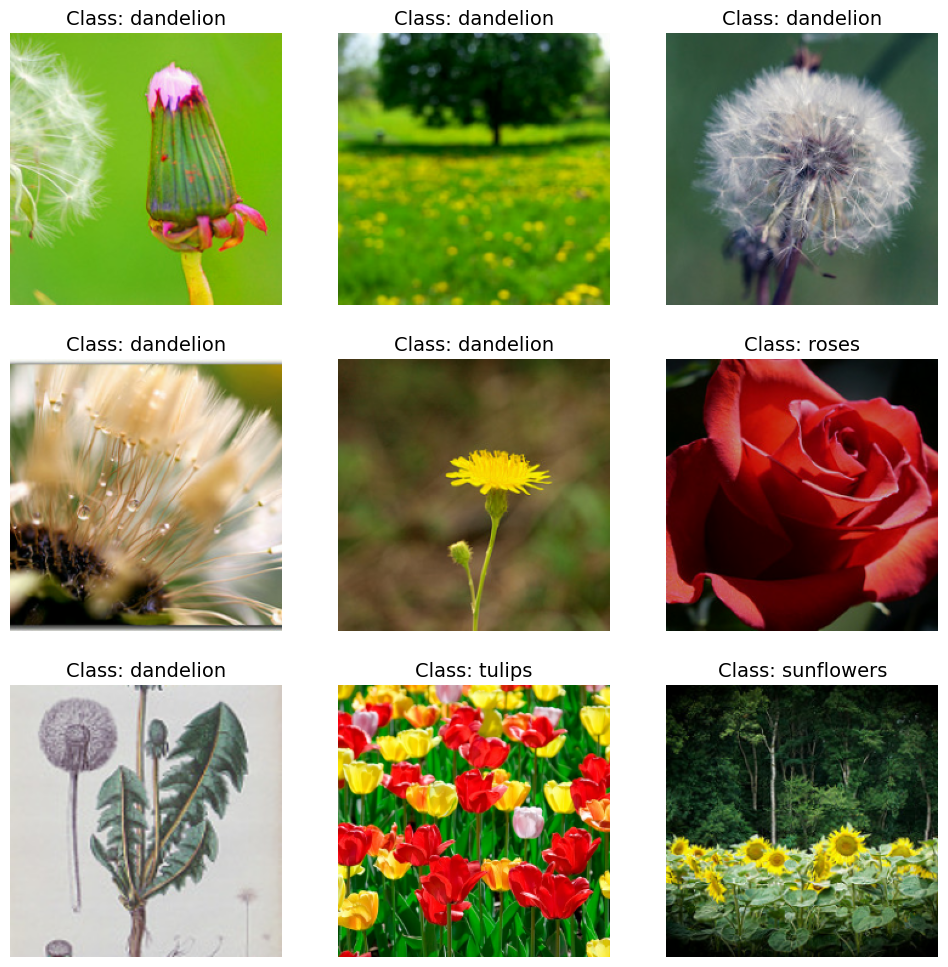

In [36]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [37]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = 'horizontal', seed = 42),
    tf.keras.layers.RandomRotation(factor = 0.05, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2, seed = 42)
])


2023-03-15 04:41:02.818800: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


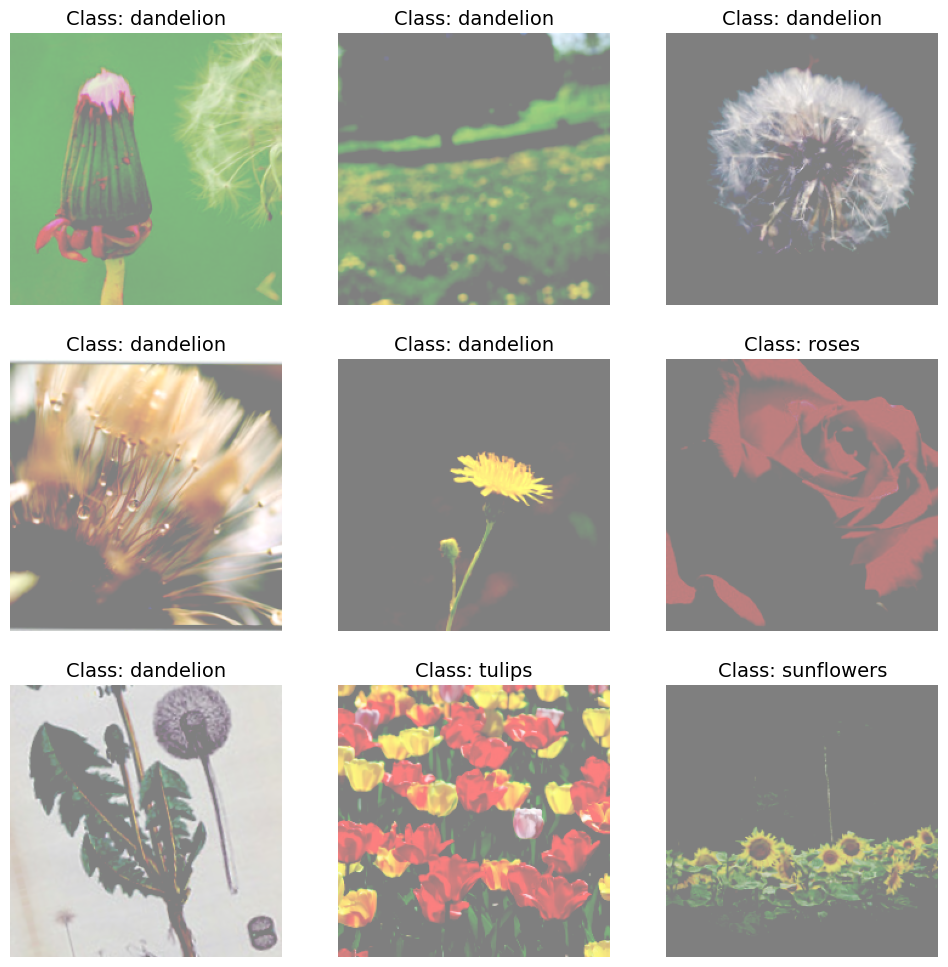

In [38]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [39]:
# LOAD PRETRAINED MODEL
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights = 'imagenet',
                                                     include_top = False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(avg)
model = tf.keras.Model(inputs = base_model.input, outputs = output)

In [40]:
for layer in base_model.layers:
    layer.trainable = False

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer,
              metrics = ['accuracy'])
history = model.fit(train_set, validation_data = valid_set, epochs = 3)

Epoch 1/3
86/86 [==============================] - 16s 148ms/step - loss: 0.7492 - accuracy: 0.8052 - val_loss: 0.6932 - val_accuracy: 0.8421
Epoch 2/3
86/86 [==============================] - 12s 134ms/step - loss: 0.3207 - accuracy: 0.9084 - val_loss: 0.6522 - val_accuracy: 0.8312
Epoch 3/3
86/86 [==============================] - 12s 134ms/step - loss: 0.1766 - accuracy: 0.9415 - val_loss: 0.7004 - val_accuracy: 0.8475


In [42]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end= "")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [43]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer,
              metrics = ['accuracy'])
history = model.fit(train_set, validation_data = valid_set, epochs = 10)

Epoch 1/10
86/86 [==============================] - 26s 249ms/step - loss: 0.2922 - accuracy: 0.9121 - val_loss: 0.4467 - val_accuracy: 0.8838
Epoch 2/10
86/86 [==============================] - 21s 240ms/step - loss: 0.0395 - accuracy: 0.9880 - val_loss: 0.3630 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 21s 240ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.3645 - val_accuracy: 0.9074
Epoch 4/10
86/86 [==============================] - 21s 241ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.3457 - val_accuracy: 0.9038
Epoch 5/10
86/86 [==============================] - 21s 241ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.3550 - val_accuracy: 0.9056
Epoch 6/10
86/86 [==============================] - 21s 240ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.3490 - val_accuracy: 0.9056
Epoch 7/10
86/86 [==============================] - 21s 241ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.3574 - val_accuracy: 0.9093

## Classification and Localization ##

In [44]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [45]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 11s 564ms/step - loss: 1.2157 - dense_1_loss: 1.4583 - dense_2_loss: 0.2450 - dense_1_accuracy: 0.4219 - dense_2_accuracy: 0.2594
Epoch 2/2
10/10 [==============================] - 6s 569ms/step - loss: 0.7974 - dense_1_loss: 0.9474 - dense_2_loss: 0.1972 - dense_1_accuracy: 0.7594 - dense_2_accuracy: 0.2812


## How mAP Relates to Precision/Recall ##

In [46]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

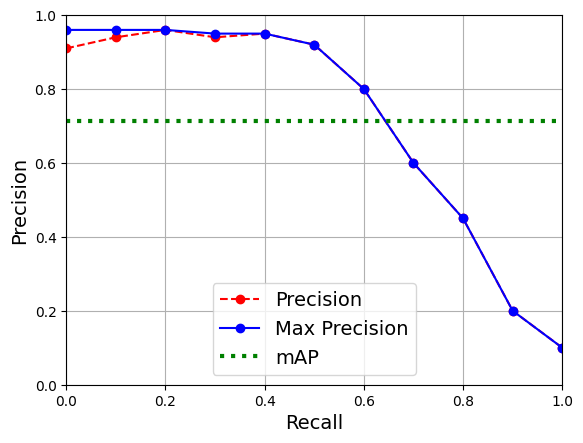

In [47]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()